In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42 #for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/isaacanwar/Desktop/Projects/Classification-RAG-gaurdrail/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [4]:
# Model Config
MODEL_NAME = "answerdotai/ModernBERT-base"
MAX_LENGTH = 256  # Increased to fit both texts
HIDDEN_DIM = 256
DROPOUT = 0.3

# Embedding dimensions
INTENT_EMBED_DIM = 32
STAGE_EMBED_DIM = 32
INTENT_HISTORY_LEN = 3

# Training configuration
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 64
LEARNING_RATE = 2e-5
NUM_EPOCHS = 15
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
PATIENCE = 3  # Early stopping patience

# Label mappings for Layer 2 multi-class classification
id2label = {
    0: "answer_submission",
    1: "clarification_request",
    2: "process_inquiry",
    3: "challenge_assessment",
    4: "off_topic",
    5: "small_talk"
}
label2id = {v: k for k, v in id2label.items()}
NUM_LABELS = len(id2label)

# Stage mappings (4 stages)
stage2id = {
    "opening": 0,
    "technical_depth": 1,
    "challenge": 2,
    "closing": 3
}
id2stage = {v: k for k, v in stage2id.items()}
NUM_STAGES = len(stage2id)

# Intent padding index (for -1 values in history)
INTENT_PADDING_IDX = NUM_LABELS  # Index 6 for padding

print(f"Number of intent classes: {NUM_LABELS}")
print(f"Intent labels: {list(id2label.values())}")
print(f"Number of stages: {NUM_STAGES}")
print(f"Stages: {list(stage2id.keys())}")

Number of intent classes: 6
Intent labels: ['answer_submission', 'clarification_request', 'process_inquiry', 'challenge_assessment', 'off_topic', 'small_talk']
Number of stages: 4
Stages: ['opening', 'technical_depth', 'challenge', 'closing']


In [5]:
# Expected CSV columns: current_query, prev_system_msg, prev_intents, interview_stage, label
df = pd.read_csv('layer2_contextual_data.csv')

# Clean data
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
df = df[df['label'].isin([0, 1, 2, 3, 4, 5])].copy()

# Parse prev_intents from string to list
def parse_intents(intent_str):
    """Convert string like '[-1, -1, 0]' to list of ints"""
    try:
        return ast.literal_eval(intent_str)
    except:
        return [-1, -1, -1]

df['prev_intents_parsed'] = df['prev_intents'].apply(parse_intents)

# Validate stages
df = df[df['interview_stage'].isin(stage2id.keys())].copy()

print(f"Loaded {len(df)} samples")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())
print(f"\nStage distribution:")
print(df['interview_stage'].value_counts())
df.head(5)

Loaded 4710 samples

Label distribution:
label
0    1245
1    1191
2     783
3     286
4     363
5     842
Name: count, dtype: int64

Stage distribution:
interview_stage
technical_depth    2799
opening             842
closing             669
challenge           400
Name: count, dtype: int64


,current_query,prev_system_msg,prev_intents,interview_stage,label,prev_intents_parsed
0,Hi there,Welcome to your finance interview. We'll cover...,"[-1, -1, -1]",opening,5,"[-1, -1, -1]"
1,What is the general structure of this meeting?,We will start with a few basics and then dive ...,"[-1, -1, 5]",opening,2,"[-1, -1, 5]"
2,Could you explain what specific valuation meth...,Let's start with your understanding of the Thr...,"[-1, 5, 2]",technical_depth,1,"[-1, 5, 2]"
3,The Income Statement,"Balance Sheet, and Cash Flow Statement are lin...","[5, 2, 1]",technical_depth,0,"[5, 2, 1]"
4,Is that a pre-tax or post-tax depreciation amo...,Assume a 20% corporate tax rate for this calcu...,"[2, 1, 0]",technical_depth,1,"[2, 1, 0]"


In [6]:
# First split: 70% train, 30% val/test
train_df, temp_df = train_test_split(
    df, 
    test_size=0.30, 
    random_state=RANDOM_SEED, 
    stratify=df['label']
)

# Second split: 15% val, 15% test (50-50 split of the 30%)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=RANDOM_SEED, 
    stratify=temp_df['label']
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train size: 3297 (70.0%)
Val size: 706 (15.0%)
Test size: 707 (15.0%)


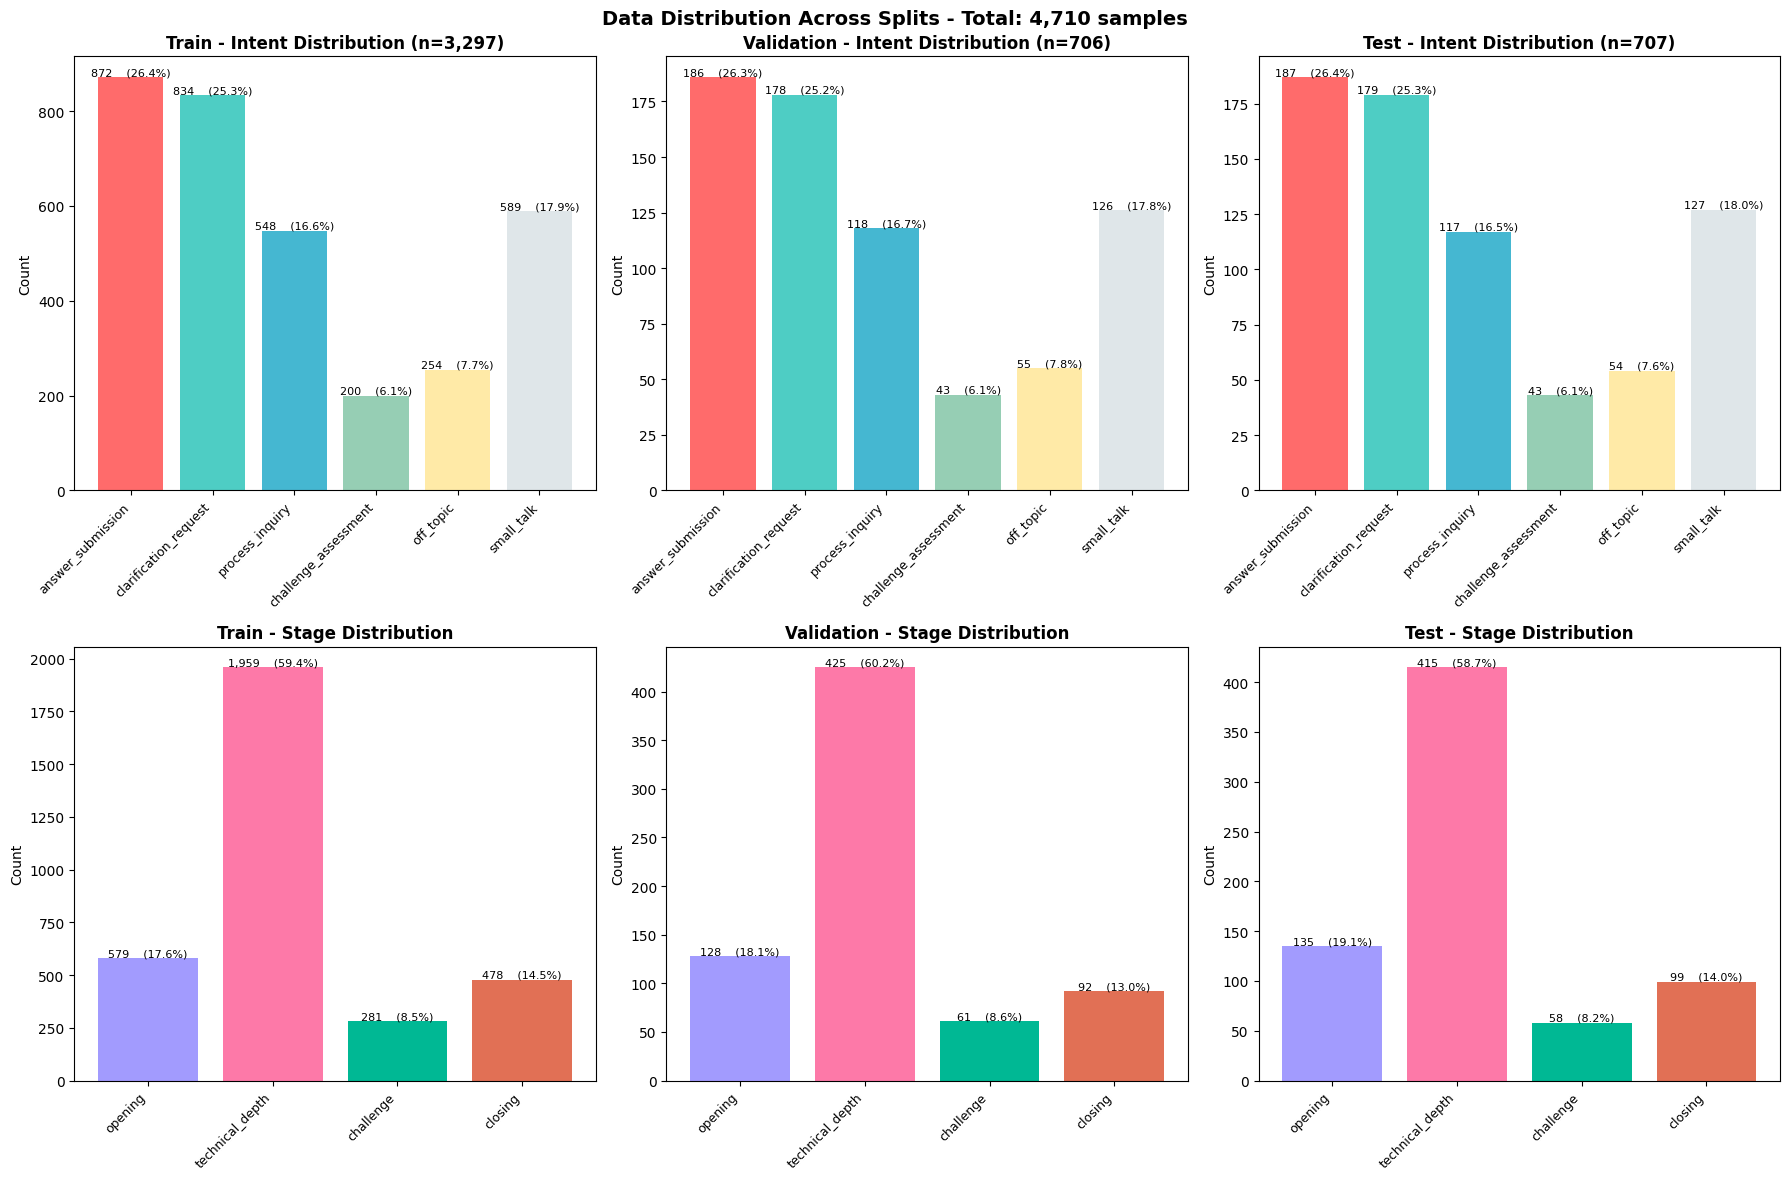

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

splits = [
    ('Train', train_df),
    ('Validation', val_df),
    ('Test', test_df)
]

colors_intent = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#dfe6e9']
colors_stage = ['#a29bfe', '#fd79a8', '#00b894', '#e17055']
class_names = [id2label[i] for i in range(NUM_LABELS)]
stage_names = list(stage2id.keys())

# Row 1: Intent distribution
for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['label'].value_counts().sort_index()
    percentages = (counts / len(split_df) * 100)
    
    bars = axes[0, idx].bar(range(NUM_LABELS), counts.values, color=colors_intent)
    axes[0, idx].set_title(f'{split_name} - Intent Distribution (n={len(split_df):,})', fontsize=12, fontweight='bold')
    axes[0, idx].set_ylabel('Count')
    axes[0, idx].set_xticks(range(NUM_LABELS))
    axes[0, idx].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        label = f'{count:,}    ({pct:.1f}%)'
        axes[0, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                          label, ha='center', va='bottom', fontsize=8)

# Row 2: Stage distribution
for idx, (split_name, split_df) in enumerate(splits):
    counts = split_df['interview_stage'].value_counts()
    # Reorder to match stage2id
    counts = counts.reindex(stage_names)
    percentages = (counts / len(split_df) * 100)
    
    bars = axes[1, idx].bar(range(NUM_STAGES), counts.values, color=colors_stage)
    axes[1, idx].set_title(f'{split_name} - Stage Distribution', fontsize=12, fontweight='bold')
    axes[1, idx].set_ylabel('Count')
    axes[1, idx].set_xticks(range(NUM_STAGES))
    axes[1, idx].set_xticklabels(stage_names, rotation=45, ha='right', fontsize=9)
    
    for bar, count, pct in zip(bars, counts.values, percentages.values):
        label = f'{count:,}    ({pct:.1f}%)'
        axes[1, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                          label, ha='center', va='bottom', fontsize=8)

plt.suptitle(f'Data Distribution Across Splits - Total: {len(df):,} samples', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
class ContextualIntentDataset(TorchDataset):
    """Dataset for combined context-aware intent classification."""
    
    def __init__(self, df, tokenizer, max_length=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Combine texts with separator: [prev_msg] [SEP] [current_query]
        prev_msg = str(row['prev_system_msg']) if pd.notna(row['prev_system_msg']) else ""
        current_query = str(row['current_query'])
        combined_text = f"{prev_msg} {self.tokenizer.sep_token} {current_query}"
        
        # Tokenize combined text
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # Process intent history (convert -1 to padding index)
        prev_intents = row['prev_intents_parsed']
        prev_intents_tensor = torch.tensor([
            idx if idx != -1 else INTENT_PADDING_IDX 
            for idx in prev_intents
        ], dtype=torch.long)
        
        # Convert stage to integer
        stage = stage2id[row['interview_stage']]
        
        # Label
        label = row['label']
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'prev_intents': prev_intents_tensor,
            'interview_stage': torch.tensor(stage, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long),
            # Store metadata for stratified evaluation
            'stage_name': row['interview_stage'],
            'is_first_turn': all(i == -1 for i in prev_intents)
        }

In [18]:
class ContextAwareLayer2Classifier(nn.Module):
    """
    Context-aware intent classifier that combines:
    - Text encoding (ModernBERT with [prev_msg] [SEP] [current_query])
    - Intent history embeddings (3 positions, right-aligned)
    - Interview stage embedding
    """
    
    def __init__(
        self,
        model_name: str = "answerdotai/ModernBERT-base",
        num_labels: int = 6,
        num_stages: int = 4,
        intent_history_len: int = 3,
        intent_embed_dim: int = 32,
        stage_embed_dim: int = 32,
        hidden_dim: int = 256,
        dropout: float = 0.3,
        intent_padding_idx: int = 6
    ):
        super().__init__()
        
        self.num_labels = num_labels
        self.intent_history_len = intent_history_len
        
        # ModernBERT encoder for text
        self.bert = AutoModel.from_pretrained(model_name)
        self.bert_hidden_size = self.bert.config.hidden_size  # 768
        
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Intent history embeddings
        # num_embeddings = num_labels + 1 (for padding)
        self.intent_embeddings = nn.Embedding(
            num_embeddings=num_labels + 1,
            embedding_dim=intent_embed_dim,
            padding_idx=intent_padding_idx
        )
        
        # Stage embedding
        self.stage_embedding = nn.Embedding(
            num_embeddings=num_stages,
            embedding_dim=stage_embed_dim
        )
        
        # Calculate combined dimension
        # BERT (768) + intent history (3 * 32 = 96) + stage (32) = 896
        combined_dim = self.bert_hidden_size + (intent_history_len * intent_embed_dim) + stage_embed_dim
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )
        
        # Store config for saving/loading
        self.config = {
            'model_name': model_name,
            'num_labels': num_labels,
            'num_stages': num_stages,
            'intent_history_len': intent_history_len,
            'intent_embed_dim': intent_embed_dim,
            'stage_embed_dim': stage_embed_dim,
            'hidden_dim': hidden_dim,
            'dropout': dropout,
            'intent_padding_idx': intent_padding_idx,
            'combined_dim': combined_dim
        }
        
        print(f"Model architecture:")
        print(f"  BERT hidden size: {self.bert_hidden_size}")
        print(f"  Intent history: {intent_history_len} x {intent_embed_dim} = {intent_history_len * intent_embed_dim}")
        print(f"  Stage embedding: {stage_embed_dim}")
        print(f"  Combined dimension: {combined_dim}")
        print(f"  Output classes: {num_labels}")
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        prev_intents: torch.Tensor,
        interview_stage: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            input_ids: Tokenized text [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]
            prev_intents: Intent history [batch_size, 3]
            interview_stage: Stage indices [batch_size]
        
        Returns:
            logits: Classification logits [batch_size, num_labels]
        """
        # 1. Encode text through BERT
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use [CLS] token embedding
        text_embedding = bert_output.last_hidden_state[:, 0, :]  # [batch_size, 768]
        
        # 2. Embed intent history
        intent_emb = self.intent_embeddings(prev_intents)  # [batch_size, 3, 32]
        intent_emb = intent_emb.view(intent_emb.size(0), -1)  # [batch_size, 96]
        
        # 3. Embed stage
        stage_emb = self.stage_embedding(interview_stage)  # [batch_size, 32]
        
        # 4. Concatenate all embeddings
        combined = torch.cat([text_embedding, intent_emb, stage_emb], dim=-1)  # [batch_size, 896]
        
        # 5. Classification
        logits = self.classifier(combined)  # [batch_size, num_labels]
        
        return logits
    
    def count_parameters(self):
        """Count trainable and frozen parameters."""
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen = sum(p.numel() for p in self.parameters() if not p.requires_grad)
        return trainable, frozen

In [19]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = ContextAwareLayer2Classifier(
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    num_stages=NUM_STAGES,
    intent_history_len=INTENT_HISTORY_LEN,
    intent_embed_dim=INTENT_EMBED_DIM,
    stage_embed_dim=STAGE_EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    intent_padding_idx=INTENT_PADDING_IDX
)

model = model.to(device)

# Count parameters
trainable, frozen = model.count_parameters()
print(f"\nTrainable parameters: {trainable:,}")
print(f"Frozen parameters: {frozen:,}")
print(f"Total parameters: {trainable + frozen:,}")

Loading weights: 100%|██████████| 134/134 [00:00<00:00, 1882.84it/s, Materializing param=layers.21.mlp_norm.weight]    
ModernBertModel LOAD REPORT from: answerdotai/ModernBERT-base
Key               | Status     |  | 
------------------+------------+--+-
head.dense.weight | UNEXPECTED |  | 
decoder.bias      | UNEXPECTED |  | 
head.norm.weight  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model architecture:
  BERT hidden size: 768
  Intent history: 3 x 32 = 96
  Stage embedding: 32
  Combined dimension: 896
  Output classes: 6

Trainable parameters: 231,526
Frozen parameters: 149,014,272
Total parameters: 149,245,798


In [20]:
train_dataset = ContextualIntentDataset(train_df, tokenizer, MAX_LENGTH)
val_dataset = ContextualIntentDataset(val_df, tokenizer, MAX_LENGTH)
test_dataset = ContextualIntentDataset(test_df, tokenizer, MAX_LENGTH)

def collate_fn(batch):
    """Custom collate function to handle metadata."""
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'prev_intents': torch.stack([item['prev_intents'] for item in batch]),
        'interview_stage': torch.stack([item['interview_stage'] for item in batch]),
        'labels': torch.stack([item['labels'] for item in batch]),
        'stage_name': [item['stage_name'] for item in batch],
        'is_first_turn': [item['is_first_turn'] for item in batch]
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 104
Val batches: 12
Test batches: 12


In [21]:
def compute_metrics(all_labels, all_preds, all_probs, all_stages, all_first_turn):
    """
    Compute comprehensive metrics including stratified evaluations.
    
    Args:
        all_labels: True labels
        all_preds: Predicted labels
        all_probs: Prediction probabilities
        all_stages: Stage names for each sample
        all_first_turn: Boolean for first turn samples
    
    Returns:
        Dictionary of metrics
    """
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_stages = np.array(all_stages)
    all_first_turn = np.array(all_first_turn)
    
    confidence = np.max(all_probs, axis=-1)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average=None, labels=list(range(NUM_LABELS)), zero_division=0
    )
    
    # Macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    # Per-class AUC
    per_class_auc = []
    for i in range(NUM_LABELS):
        binary_labels = (all_labels == i).astype(int)
        if binary_labels.sum() > 0 and binary_labels.sum() < len(binary_labels):
            auc = roc_auc_score(binary_labels, all_probs[:, i])
        else:
            auc = 0.0
        per_class_auc.append(auc)
    
    # Confidence stats
    correct_mask = all_preds == all_labels
    
    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "macro_f1": macro_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_auc": np.mean(per_class_auc),
        "confidence_mean": confidence.mean(),
        "confidence_correct": confidence[correct_mask].mean() if correct_mask.any() else 0.0,
        "confidence_wrong": confidence[~correct_mask].mean() if (~correct_mask).any() else 0.0,
    }
    
    # Per-class metrics
    for i, label_name in id2label.items():
        metrics[f"f1_{label_name}"] = f1[i]
        metrics[f"precision_{label_name}"] = precision[i]
        metrics[f"recall_{label_name}"] = recall[i]
        metrics[f"auc_{label_name}"] = per_class_auc[i]
    
   # 1. Accuracy by interview stage
    for stage_name in stage2id.keys():
        stage_mask = all_stages == stage_name
        if stage_mask.sum() > 0:
            stage_acc = accuracy_score(all_labels[stage_mask], all_preds[stage_mask])
            metrics[f"accuracy_stage_{stage_name}"] = stage_acc
        else:
            metrics[f"accuracy_stage_{stage_name}"] = 0.0
    
    # 2. Accuracy for first turn vs later turns
    first_turn_mask = all_first_turn
    later_turn_mask = ~all_first_turn
    
    if first_turn_mask.sum() > 0:
        metrics["accuracy_first_turn"] = accuracy_score(
            all_labels[first_turn_mask], all_preds[first_turn_mask]
        )
    else:
        metrics["accuracy_first_turn"] = 0.0
    
    if later_turn_mask.sum() > 0:
        metrics["accuracy_later_turns"] = accuracy_score(
            all_labels[later_turn_mask], all_preds[later_turn_mask]
        )
    else:
        metrics["accuracy_later_turns"] = 0.0
    
    # Sample counts for reference
    metrics["n_first_turn"] = int(first_turn_mask.sum())
    metrics["n_later_turns"] = int(later_turn_mask.sum())
    for stage_name in stage2id.keys():
        metrics[f"n_stage_{stage_name}"] = int((all_stages == stage_name).sum())
    
    return metrics

In [22]:
def evaluate(model, dataloader, device):
    """Evaluate model and return metrics."""
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    all_stages = []
    all_first_turn = []
    total_loss = 0.0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            prev_intents = batch['prev_intents'].to(device)
            interview_stage = batch['interview_stage'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask, prev_intents, interview_stage)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            preds = np.argmax(probs, axis=-1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)
            all_stages.extend(batch['stage_name'])
            all_first_turn.extend(batch['is_first_turn'])
    
    avg_loss = total_loss / len(dataloader)
    metrics = compute_metrics(all_labels, all_preds, all_probs, all_stages, all_first_turn)
    metrics['loss'] = avg_loss
    
    return metrics, all_labels, all_preds, all_probs

In [23]:
# Optimizer (only trainable parameters)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

criterion = nn.CrossEntropyLoss()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_macro_f1': []
}

best_val_f1 = 0.0
patience_counter = 0
best_model_state = None

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"Total steps: {total_steps}, Warmup steps: {warmup_steps}")
print("=" * 80)

Starting training for 15 epochs...
Total steps: 1560, Warmup steps: 156


In [24]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        prev_intents = batch['prev_intents'].to(device)
        interview_stage = batch['interview_stage'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask, prev_intents, interview_stage)
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Validation
    val_metrics, _, _, _ = evaluate(model, val_loader, device)
    
    # Update history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['val_accuracy'].append(val_metrics['accuracy'])
    history['val_macro_f1'].append(val_metrics['macro_f1'])
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {val_metrics['loss']:.4f}")
    print(f"  Val Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  Val Macro F1: {val_metrics['macro_f1']:.4f}")
    print(f"  Val Accuracy (First Turn): {val_metrics['accuracy_first_turn']:.4f}")
    print(f"  Val Accuracy (Later Turns): {val_metrics['accuracy_later_turns']:.4f}")
    
    # Early stopping check
    if val_metrics['macro_f1'] > best_val_f1:
        best_val_f1 = val_metrics['macro_f1']
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best model! (Macro F1: {best_val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break
    
    print("=" * 80)

print(f"\nTraining complete! Best Macro F1: {best_val_f1:.4f}")

Epoch 1/15: 100%|██████████| 104/104 [03:08<00:00,  1.81s/it, loss=1.5206]



Epoch 1/15
  Train Loss: 1.7344
  Val Loss: 1.6098
  Val Accuracy: 0.3640
  Val Macro F1: 0.1588
  Val Accuracy (First Turn): 0.0000
  Val Accuracy (Later Turns): 0.4009
  ✓ New best model! (Macro F1: 0.1588)


Epoch 2/15: 100%|██████████| 104/104 [03:09<00:00,  1.83s/it, loss=1.2906]



Epoch 2/15
  Train Loss: 1.4858
  Val Loss: 1.3199
  Val Accuracy: 0.6700
  Val Macro F1: 0.4759
  Val Accuracy (First Turn): 0.0769
  Val Accuracy (Later Turns): 0.7301
  ✓ New best model! (Macro F1: 0.4759)


Epoch 3/15: 100%|██████████| 104/104 [03:12<00:00,  1.85s/it, loss=1.2814]



Epoch 3/15
  Train Loss: 1.2262
  Val Loss: 1.0974
  Val Accuracy: 0.7720
  Val Macro F1: 0.5558
  Val Accuracy (First Turn): 0.8154
  Val Accuracy (Later Turns): 0.7676
  ✓ New best model! (Macro F1: 0.5558)


Epoch 4/15: 100%|██████████| 104/104 [03:15<00:00,  1.88s/it, loss=0.5801]



Epoch 4/15
  Train Loss: 1.0233
  Val Loss: 0.9206
  Val Accuracy: 0.7975
  Val Macro F1: 0.5989
  Val Accuracy (First Turn): 0.8154
  Val Accuracy (Later Turns): 0.7956
  ✓ New best model! (Macro F1: 0.5989)


Epoch 5/15: 100%|██████████| 104/104 [03:20<00:00,  1.93s/it, loss=0.6967]



Epoch 5/15
  Train Loss: 0.8614
  Val Loss: 0.7871
  Val Accuracy: 0.8428
  Val Macro F1: 0.7100
  Val Accuracy (First Turn): 0.9385
  Val Accuracy (Later Turns): 0.8331
  ✓ New best model! (Macro F1: 0.7100)


Epoch 6/15: 100%|██████████| 104/104 [03:28<00:00,  2.00s/it, loss=0.5038]



Epoch 6/15
  Train Loss: 0.7496
  Val Loss: 0.6873
  Val Accuracy: 0.8725
  Val Macro F1: 0.7739
  Val Accuracy (First Turn): 0.9385
  Val Accuracy (Later Turns): 0.8658
  ✓ New best model! (Macro F1: 0.7739)


Epoch 7/15: 100%|██████████| 104/104 [03:22<00:00,  1.94s/it, loss=0.1994]



Epoch 7/15
  Train Loss: 0.6571
  Val Loss: 0.6130
  Val Accuracy: 0.8952
  Val Macro F1: 0.8126
  Val Accuracy (First Turn): 0.9385
  Val Accuracy (Later Turns): 0.8908
  ✓ New best model! (Macro F1: 0.8126)


Epoch 8/15: 100%|██████████| 104/104 [03:14<00:00,  1.87s/it, loss=0.1980]



Epoch 8/15
  Train Loss: 0.5884
  Val Loss: 0.5526
  Val Accuracy: 0.9136
  Val Macro F1: 0.8511
  Val Accuracy (First Turn): 0.9846
  Val Accuracy (Later Turns): 0.9064
  ✓ New best model! (Macro F1: 0.8511)


Epoch 9/15: 100%|██████████| 104/104 [03:14<00:00,  1.87s/it, loss=0.1352]



Epoch 9/15
  Train Loss: 0.5316
  Val Loss: 0.5095
  Val Accuracy: 0.9178
  Val Macro F1: 0.8644
  Val Accuracy (First Turn): 0.9692
  Val Accuracy (Later Turns): 0.9126
  ✓ New best model! (Macro F1: 0.8644)


Epoch 10/15: 100%|██████████| 104/104 [03:23<00:00,  1.95s/it, loss=0.7590]



Epoch 10/15
  Train Loss: 0.4995
  Val Loss: 0.4742
  Val Accuracy: 0.9193
  Val Macro F1: 0.8660
  Val Accuracy (First Turn): 0.9846
  Val Accuracy (Later Turns): 0.9126
  ✓ New best model! (Macro F1: 0.8660)


Epoch 11/15: 100%|██████████| 104/104 [03:16<00:00,  1.89s/it, loss=0.7048]



Epoch 11/15
  Train Loss: 0.4670
  Val Loss: 0.4488
  Val Accuracy: 0.9292
  Val Macro F1: 0.8914
  Val Accuracy (First Turn): 1.0000
  Val Accuracy (Later Turns): 0.9220
  ✓ New best model! (Macro F1: 0.8914)


Epoch 12/15: 100%|██████████| 104/104 [03:18<00:00,  1.91s/it, loss=1.2261]



Epoch 12/15
  Train Loss: 0.4522
  Val Loss: 0.4307
  Val Accuracy: 0.9292
  Val Macro F1: 0.8914
  Val Accuracy (First Turn): 1.0000
  Val Accuracy (Later Turns): 0.9220
  No improvement. Patience: 1/3


Epoch 13/15: 100%|██████████| 104/104 [03:12<00:00,  1.85s/it, loss=0.8143]



Epoch 13/15
  Train Loss: 0.4338
  Val Loss: 0.4177
  Val Accuracy: 0.9292
  Val Macro F1: 0.8914
  Val Accuracy (First Turn): 1.0000
  Val Accuracy (Later Turns): 0.9220
  ✓ New best model! (Macro F1: 0.8914)


Epoch 14/15: 100%|██████████| 104/104 [03:24<00:00,  1.97s/it, loss=0.3129]



Epoch 14/15
  Train Loss: 0.4166
  Val Loss: 0.4104
  Val Accuracy: 0.9320
  Val Macro F1: 0.8986
  Val Accuracy (First Turn): 1.0000
  Val Accuracy (Later Turns): 0.9251
  ✓ New best model! (Macro F1: 0.8986)


Epoch 15/15: 100%|██████████| 104/104 [03:27<00:00,  1.99s/it, loss=0.1433]



Epoch 15/15
  Train Loss: 0.4113
  Val Loss: 0.4080
  Val Accuracy: 0.9320
  Val Macro F1: 0.8987
  Val Accuracy (First Turn): 1.0000
  Val Accuracy (Later Turns): 0.9251
  ✓ New best model! (Macro F1: 0.8987)

Training complete! Best Macro F1: 0.8987


In [25]:
# ============================================================
# LOAD BEST MODEL AND SAVE
# ============================================================

# Load best model state
model.load_state_dict(best_model_state)

# Save model
import os
save_dir = "./layer2_contextual_model"
os.makedirs(save_dir, exist_ok=True)

# Save model state and config
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model.config,
    'id2label': id2label,
    'label2id': label2id,
    'stage2id': stage2id,
    'id2stage': id2stage
}, os.path.join(save_dir, 'model.pt'))

# Save tokenizer
tokenizer.save_pretrained(save_dir)

print(f"✓ Model saved to {save_dir}")

✓ Model saved to ./layer2_contextual_model


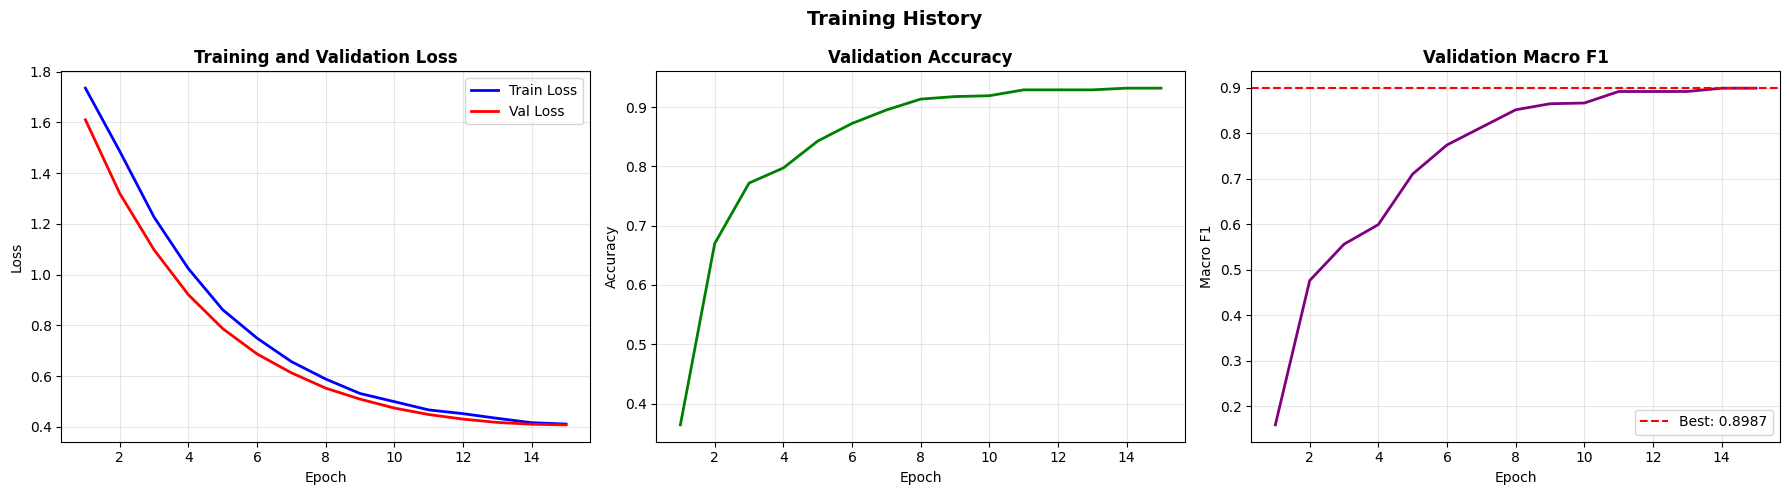

In [26]:
# ============================================================
# TRAINING HISTORY VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['val_accuracy'], 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Macro F1
axes[2].plot(epochs_range, history['val_macro_f1'], 'purple', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1')
axes[2].set_title('Validation Macro F1', fontweight='bold')
axes[2].axhline(y=best_val_f1, color='red', linestyle='--', label=f'Best: {best_val_f1:.4f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [27]:
# ============================================================
# TEST SET EVALUATION
# ============================================================

test_metrics, test_labels, test_preds, test_probs = evaluate(model, test_loader, device)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"\nOverall Metrics:")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Macro F1: {test_metrics['macro_f1']:.4f}")
print(f"  Macro Precision: {test_metrics['macro_precision']:.4f}")
print(f"  Macro Recall: {test_metrics['macro_recall']:.4f}")
print(f"  Macro AUC: {test_metrics['macro_auc']:.4f}")

print(f"\nConfidence Statistics:")
print(f"  Mean Confidence: {test_metrics['confidence_mean']:.4f}")
print(f"  Confidence (Correct): {test_metrics['confidence_correct']:.4f}")
print(f"  Confidence (Wrong): {test_metrics['confidence_wrong']:.4f}")

print(f"\nStratified by Turn:")
print(f"  First Turn Accuracy: {test_metrics['accuracy_first_turn']:.4f} (n={test_metrics['n_first_turn']})")
print(f"  Later Turns Accuracy: {test_metrics['accuracy_later_turns']:.4f} (n={test_metrics['n_later_turns']})")

print(f"\nStratified by Stage:")
for stage_name in stage2id.keys():
    acc = test_metrics[f'accuracy_stage_{stage_name}']
    n = test_metrics[f'n_stage_{stage_name}']
    print(f"  {stage_name}: {acc:.4f} (n={n})")

TEST SET RESULTS

Overall Metrics:
  Accuracy: 0.9222
  Macro F1: 0.8811
  Macro Precision: 0.9557
  Macro Recall: 0.8687
  Macro AUC: 0.9957

Confidence Statistics:
  Mean Confidence: 0.7323
  Confidence (Correct): 0.7519
  Confidence (Wrong): 0.4998

Stratified by Turn:
  First Turn Accuracy: 0.9848 (n=66)
  Later Turns Accuracy: 0.9158 (n=641)

Stratified by Stage:
  opening: 0.9926 (n=135)
  technical_depth: 0.8699 (n=415)
  challenge: 1.0000 (n=58)
  closing: 1.0000 (n=99)


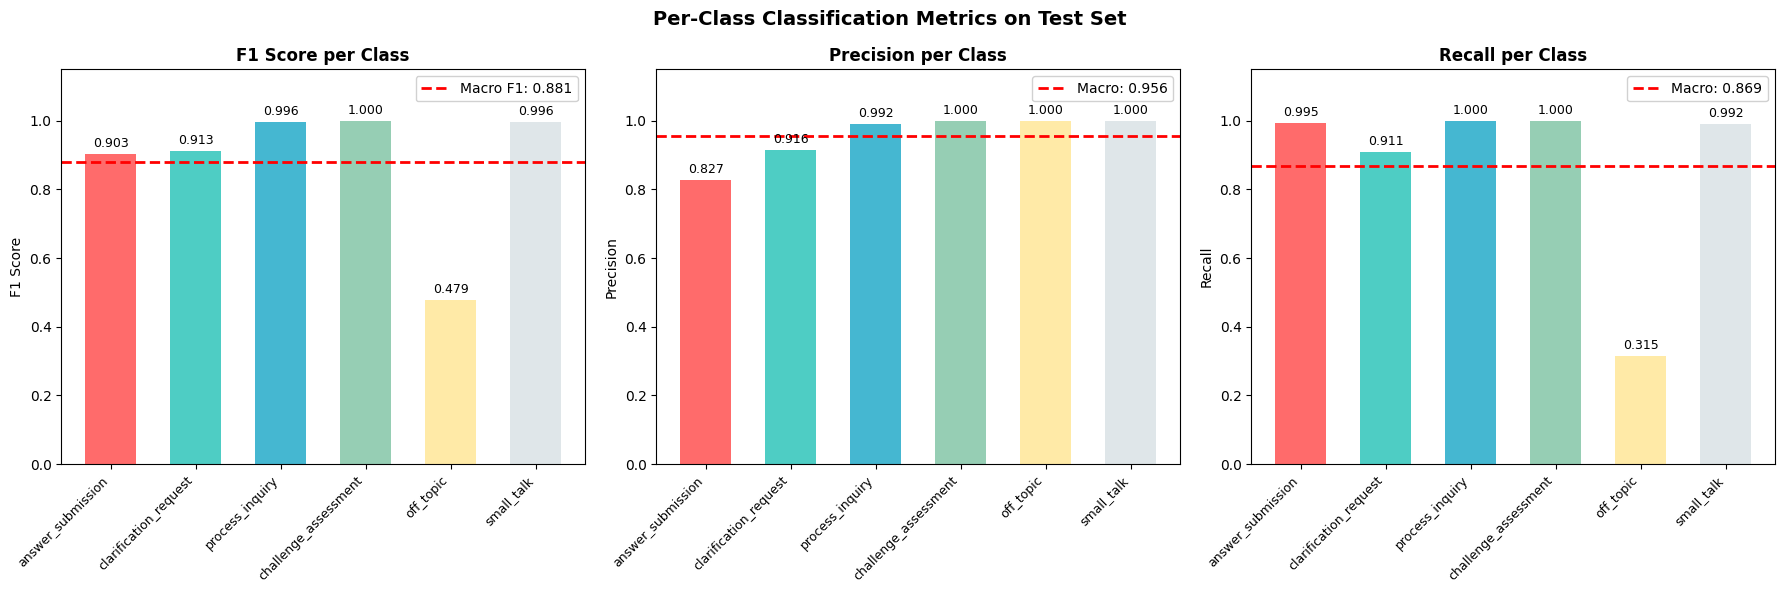

In [28]:
# ============================================================
# PER-CLASS METRICS VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_names = [id2label[i] for i in range(NUM_LABELS)]
x = np.arange(NUM_LABELS)
bar_width = 0.6
colors_intent = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#dfe6e9']

# F1 Scores
f1_scores = [test_metrics[f"f1_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[0].bar(x, f1_scores, bar_width, color=colors_intent)
axes[0].set_title('F1 Score per Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[0].set_ylim(0, 1.15)
axes[0].axhline(y=test_metrics["macro_f1"], color='red', linestyle='--', linewidth=2, 
                label=f'Macro F1: {test_metrics["macro_f1"]:.3f}')
axes[0].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, f1_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

# Precision Scores
precision_scores = [test_metrics[f"precision_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[1].bar(x, precision_scores, bar_width, color=colors_intent)
axes[1].set_title('Precision per Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[1].set_ylim(0, 1.15)
axes[1].axhline(y=test_metrics["macro_precision"], color='red', linestyle='--', linewidth=2, 
                label=f'Macro: {test_metrics["macro_precision"]:.3f}')
axes[1].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, precision_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

# Recall Scores
recall_scores = [test_metrics[f"recall_{id2label[i]}"] for i in range(NUM_LABELS)]
bars = axes[2].bar(x, recall_scores, bar_width, color=colors_intent)
axes[2].set_title('Recall per Class', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Recall')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
axes[2].set_ylim(0, 1.15)
axes[2].axhline(y=test_metrics["macro_recall"], color='red', linestyle='--', linewidth=2, 
                label=f'Macro: {test_metrics["macro_recall"]:.3f}')
axes[2].legend(loc='upper right', framealpha=0.9)
for bar, score in zip(bars, recall_scores):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{score:.3f}', ha='center', fontsize=9)

plt.suptitle('Per-Class Classification Metrics on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

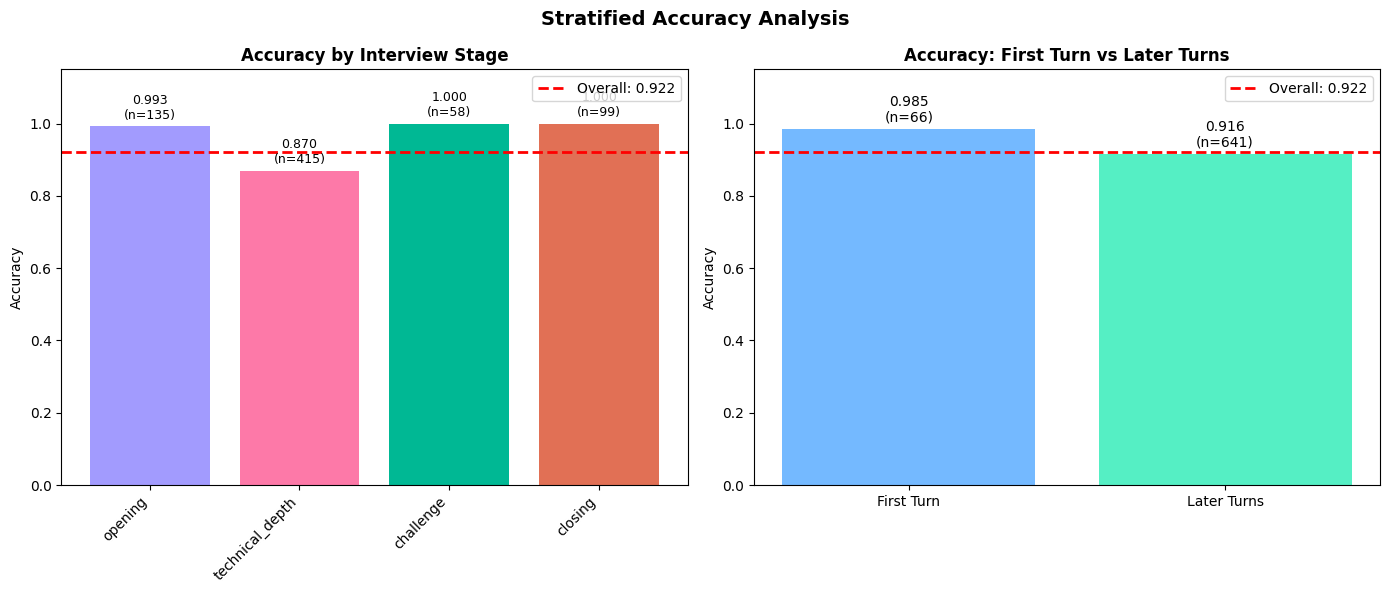

In [29]:
# ============================================================
# STRATIFIED METRICS VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Accuracy by Interview Stage
stage_names = list(stage2id.keys())
stage_accs = [test_metrics[f'accuracy_stage_{s}'] for s in stage_names]
stage_counts = [test_metrics[f'n_stage_{s}'] for s in stage_names]
colors_stage = ['#a29bfe', '#fd79a8', '#00b894', '#e17055']

bars = axes[0].bar(range(len(stage_names)), stage_accs, color=colors_stage)
axes[0].set_title('Accuracy by Interview Stage', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(stage_names)))
axes[0].set_xticklabels(stage_names, rotation=45, ha='right', fontsize=10)
axes[0].set_ylim(0, 1.15)
axes[0].axhline(y=test_metrics['accuracy'], color='red', linestyle='--', linewidth=2,
                label=f'Overall: {test_metrics["accuracy"]:.3f}')
axes[0].legend(loc='upper right')

for bar, acc, count in zip(bars, stage_accs, stage_counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{acc:.3f}\n(n={count})', ha='center', fontsize=9)

# 2. Accuracy by Turn Type (First vs Later)
turn_types = ['First Turn', 'Later Turns']
turn_accs = [test_metrics['accuracy_first_turn'], test_metrics['accuracy_later_turns']]
turn_counts = [test_metrics['n_first_turn'], test_metrics['n_later_turns']]
colors_turn = ['#74b9ff', '#55efc4']

bars = axes[1].bar(range(2), turn_accs, color=colors_turn)
axes[1].set_title('Accuracy: First Turn vs Later Turns', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(turn_types, fontsize=10)
axes[1].set_ylim(0, 1.15)
axes[1].axhline(y=test_metrics['accuracy'], color='red', linestyle='--', linewidth=2,
                label=f'Overall: {test_metrics["accuracy"]:.3f}')
axes[1].legend(loc='upper right')

for bar, acc, count in zip(bars, turn_accs, turn_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{acc:.3f}\n(n={count})', ha='center', fontsize=10)

plt.suptitle('Stratified Accuracy Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

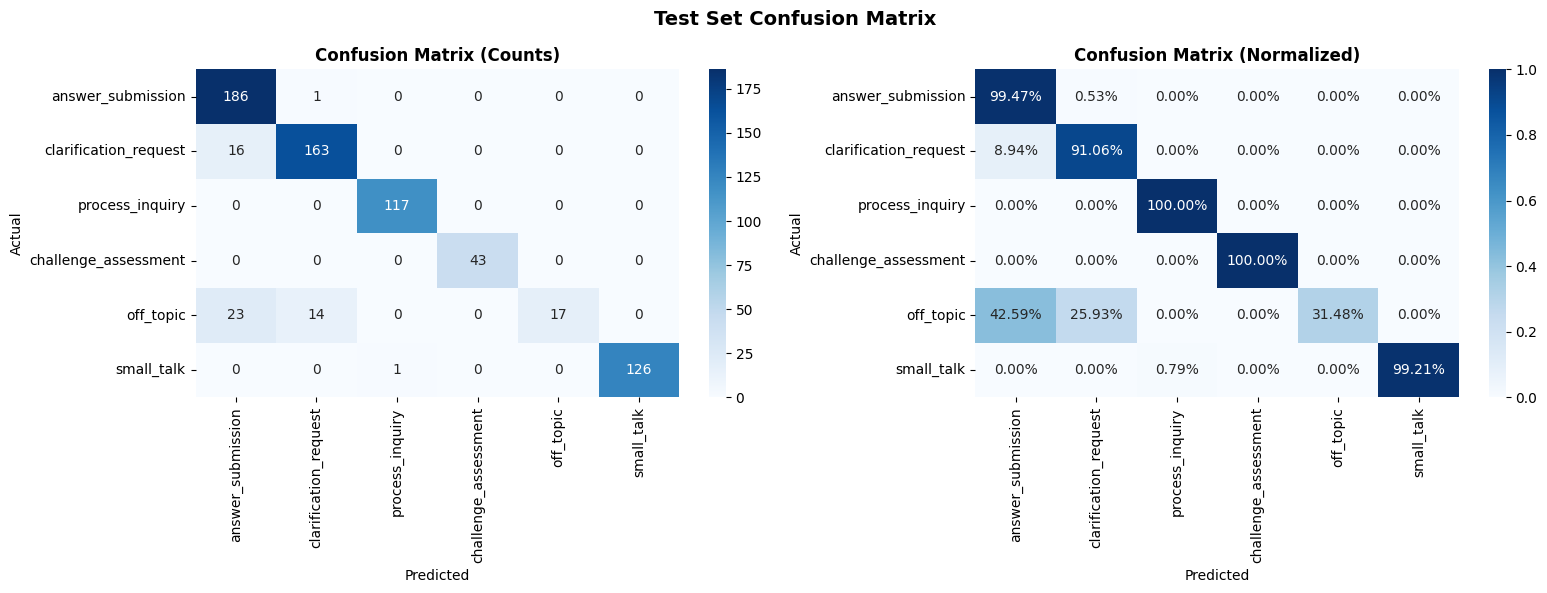

In [30]:
# ============================================================
# CONFUSION MATRIX
# ============================================================

cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_names = [id2label[i] for i in range(NUM_LABELS)]

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')

plt.suptitle('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [32]:
# ============================================================
# INTERACTIVE INFERENCE
# ============================================================

def predict(
    model,
    tokenizer,
    current_query: str,
    prev_system_msg: str = "",
    prev_intents: list = None,
    interview_stage: str = "opening",
    confidence_threshold: float = 0.5
):
    """
    Make a prediction with full context.
    
    Args:
        model: Trained model
        tokenizer: Tokenizer
        current_query: Current user query
        prev_system_msg: Previous interviewer message
        prev_intents: List of 3 previous intent IDs (right-aligned, -1 for padding)
        interview_stage: One of 'opening', 'technical_depth', 'challenge', 'closing'
        confidence_threshold: Threshold for flagging low confidence
    
    Returns:
        Dictionary with prediction results
    """
    model.eval()
    
    # Handle defaults
    if prev_intents is None:
        prev_intents = [-1, -1, -1]
    
    # Combine texts
    combined_text = f"{prev_system_msg} {tokenizer.sep_token} {current_query}"
    
    # Tokenize
    encoding = tokenizer(
        combined_text,
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_tensors='pt'
    )
    
    # Prepare inputs
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    prev_intents_tensor = torch.tensor([[
        idx if idx != -1 else INTENT_PADDING_IDX 
        for idx in prev_intents
    ]], dtype=torch.long).to(device)
    
    stage_tensor = torch.tensor([stage2id[interview_stage]], dtype=torch.long).to(device)
    
    # Forward pass
    with torch.no_grad():
        logits = model(input_ids, attention_mask, prev_intents_tensor, stage_tensor)
        probs = torch.softmax(logits, dim=-1)[0]
    
    pred_class = probs.argmax().item()
    confidence = probs[pred_class].item()
    pred_label = id2label[pred_class]
    
    # Determine status
    if confidence >= confidence_threshold:
        status = f"ACCEPTED - {pred_label}"
    else:
        status = f"FLAGGED (low confidence) - Predicted: {pred_label}"
    
    return {
        'prediction': pred_label,
        'prediction_id': pred_class,
        'confidence': confidence,
        'status': status,
        'all_probs': {id2label[i]: probs[i].item() for i in range(NUM_LABELS)}
    }

print("✓ Inference function defined")

✓ Inference function defined


In [ ]:
# ============================================================
# TEST INFERENCE
# ============================================================

# Example: Testing clarification request
test_query = "Can you explain the question again?"
test_prev_msg = "How is WACC calculated?"
test_prev_intents = [-1, -1, -1]
test_stage = "technical_depth"

result = predict(
    model=model,
    tokenizer=tokenizer,
    current_query=test_query,
    prev_system_msg=test_prev_msg,
    prev_intents=test_prev_intents,
    interview_stage=test_stage
)

print("\n" + "="*60)
print("PREDICTION ANALYSIS")
print("="*60)

# Input details
print("\n📝 Input:")
print(f"  Query: '{test_query}'")
print(f"  Prev Msg: '{test_prev_msg}'")
print(f"  Prev Intents: {test_prev_intents}")
intent_names = [id2label[i] if i != -1 else 'PADDING' for i in test_prev_intents]
print(f"    → [{intent_names[0]}, {intent_names[1]}, {intent_names[2]}]")
print(f"  Stage: {test_stage}")

# Prediction
print(f"\n🎯 Prediction: {result['prediction']} (label {label2id[result['prediction']]})")
print(f"   Confidence: {result['confidence']:.1%}")
print(f"   Status: {result['status']}")

# Calculate entropy for uncertainty measure
probs = np.array(list(result['all_probs'].values()))
entropy = -np.sum(probs * np.log(probs + 1e-10))
max_entropy = np.log(len(result['all_probs']))  # log(6) for 6 classes
certainty = 1 - (entropy / max_entropy)

print(f"   Certainty Score: {certainty:.1%}")
if certainty > 0.8:
    print("   ✅ High certainty")
elif certainty > 0.5:
    print("   ⚠️  Moderate certainty")
else:
    print("   ❌ Low certainty (model is uncertain)")

# Top 3 predictions
print("\n📊 Top 3 Predictions:")
sorted_probs = sorted(result['all_probs'].items(), key=lambda x: -x[1])
for i, (label, prob) in enumerate(sorted_probs[:3], 1):
    marker = " ← PREDICTED" if label == result['prediction'] else ""
    bar = "█" * int(prob * 40)
    print(f"  {i}. {label:25s} {prob:6.1%} {bar}{marker}")

# Competition (2nd place vs 1st place)
if len(sorted_probs) >= 2:
    gap = sorted_probs[0][1] - sorted_probs[1][1]
    print(f"\n🔍 Prediction Gap: {gap:.1%}")
    if gap < 0.1:
        print(f"   ⚠️  Close call! Model uncertain between '{sorted_probs[0][0]}' and '{sorted_probs[1][0]}'")
    elif gap < 0.25:
        print(f"   Moderate confidence")
    else:
        print(f"   ✅ Strong confidence")

# Full probability distribution
print("\n📈 Full Distribution:")
for label, prob in sorted_probs:
    marker = " ←" if label == result['prediction'] else ""
    print(f"  {label:25s} {prob:6.1%}{marker}")

print("\n" + "="*60)


PREDICTION ANALYSIS

📝 Input:
  Query: 'Can you explain the question again?'
  Prev Msg: 'How is WACC calculated?'
  Prev Intents: [-1, -1, -1]
    → [PADDING, PADDING, PADDING]
  Stage: opening

🎯 Prediction: process_inquiry (label 2)
   Confidence: 43.9%
   Status: FLAGGED (low confidence) - Predicted: process_inquiry
   Certainty Score: 21.0%
   ❌ Low certainty (model is uncertain)

📊 Top 3 Predictions:
  1. process_inquiry            43.9% █████████████████ ← PREDICTED
  2. small_talk                 23.5% █████████
  3. clarification_request      20.4% ████████

🔍 Prediction Gap: 20.4%
   Moderate confidence

📈 Full Distribution:
  process_inquiry            43.9% ←
  small_talk                 23.5%
  clarification_request      20.4%
  answer_submission           5.2%
  challenge_assessment        3.8%
  off_topic                   3.3%



In [ ]:
# ============================================================
# MODEL LOADING UTILITY (for production use)
# ============================================================

def load_model(model_dir: str, device: torch.device):
    """
    Load a saved context-aware model.
    
    Args:
        model_dir: Directory containing model.pt and tokenizer
        device: Device to load model to
    
    Returns:
        model, tokenizer, config
    """
    import os
    
    # Load checkpoint
    checkpoint = torch.load(os.path.join(model_dir, 'model.pt'), map_location=device)
    config = checkpoint['config']
    
    # Initialize model
    model = ContextAwareLayer2Classifier(**config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    
    return model, tokenizer, checkpoint

print("✓ Model loading utility defined")
print("\nUsage:")
print('  model, tokenizer, checkpoint = load_model("./layer2_contextual_model", device)')